In [2]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from skimage.io import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist import Rays_GoldenSpiral
from stardist.models import Config3D, StarDist3D, StarDistData3D
np.random.seed(42)
lbl_cmap = random_label_cmap()

from stardist import gputools_available
import gputools
from skimage.measure import label
import skimage
from skimage import io
import tifffile

ModuleNotFoundError: No module named 'gputools'

In [3]:
# Add a tensorboard output if needed


# !tensorboard --logdir='./logs' --port=16007

In [ ]:
Xname = sorted(glob('Antoine/raw/*.tiff'))
Yname = sorted(glob('Antoine/newGT/*.tiff'))

for x,y in zip(Xname, Yname):
#     print(Path(x).name)
    print(Path(y).name)

X = list(map(imread,Xname))
Y = list(map(imread,Yname))
n_channel = 1 if X[0].ndim == 3 else X[0].shape[-1]

In [3]:
axis_norm = (0,1,2)   # normalize channels independently
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 3 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|██████████| 11/11 [01:37<00:00,  8.88s/it]


In [10]:
X_trn = [X[0], X[1], X[4], X[8], X[9]]
Y_trn = [Y[0], Y[1], Y[4], Y[8], Y[9]]
X_val = [X[2], X[7], X[10]]
Y_val = [Y[2], Y[7], Y[10]]

print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images:  15
- training:         5
- validation:       3


IndexError: list index out of range

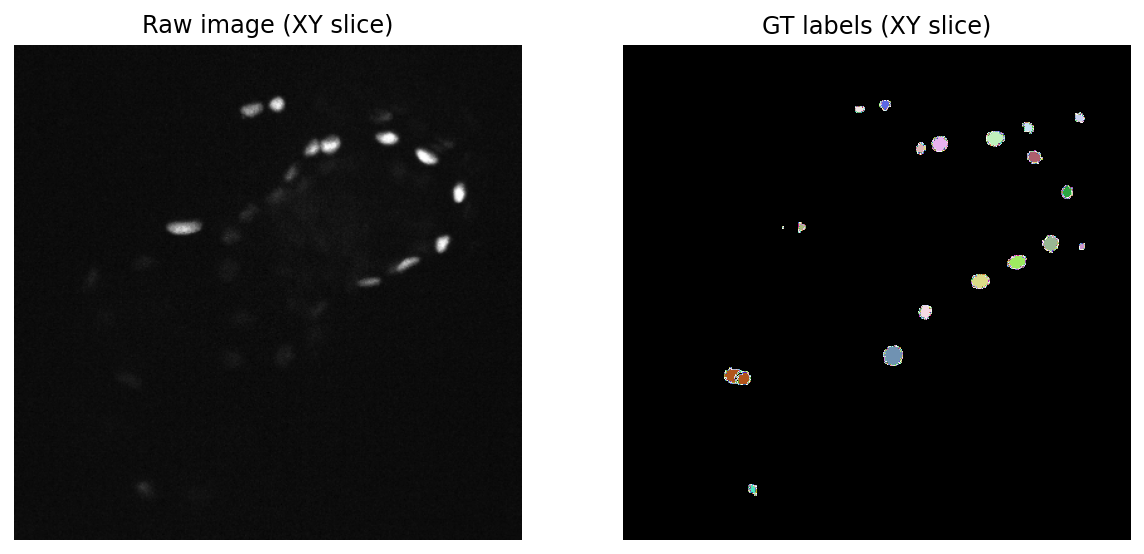

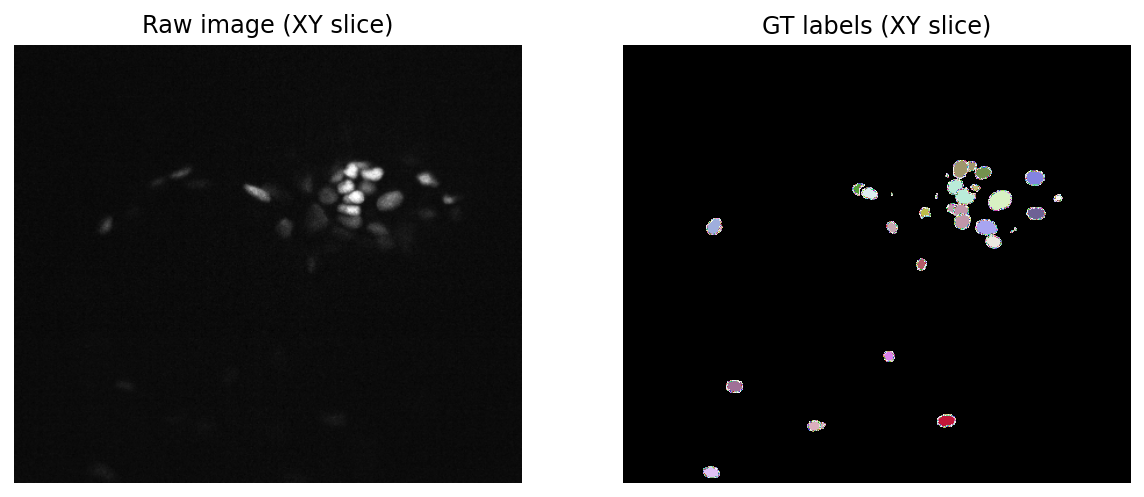

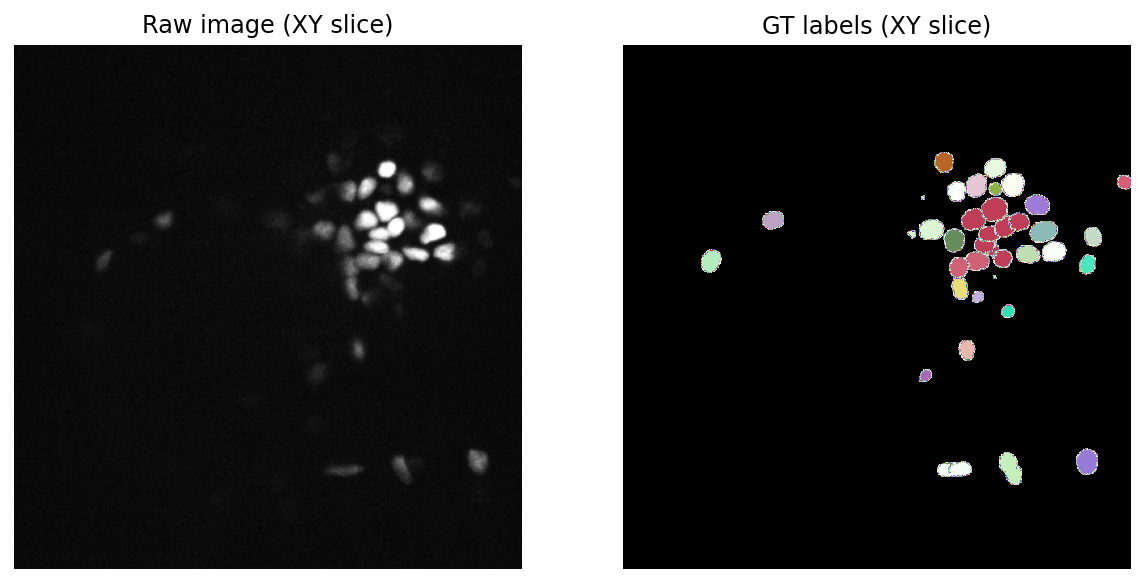

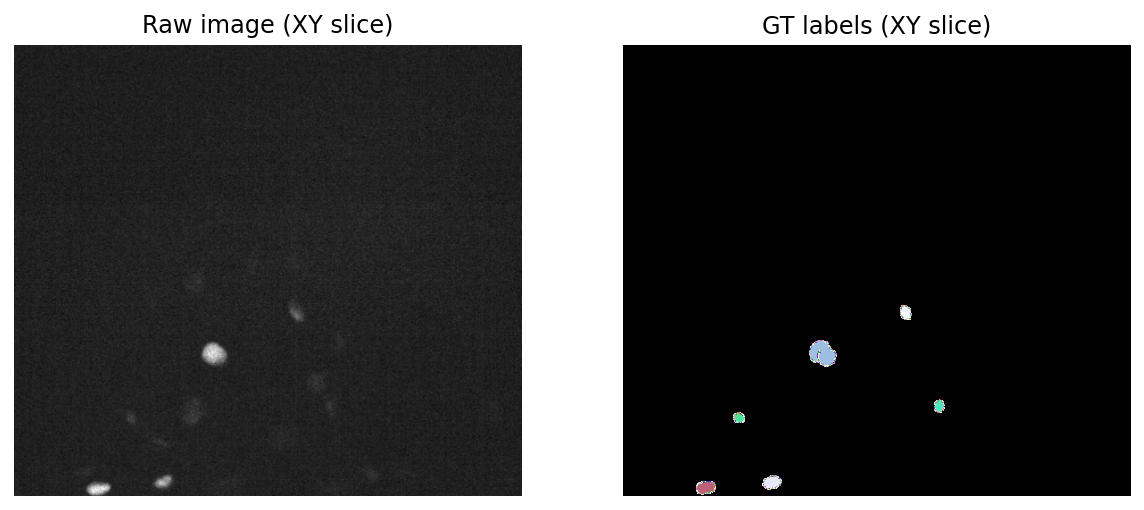

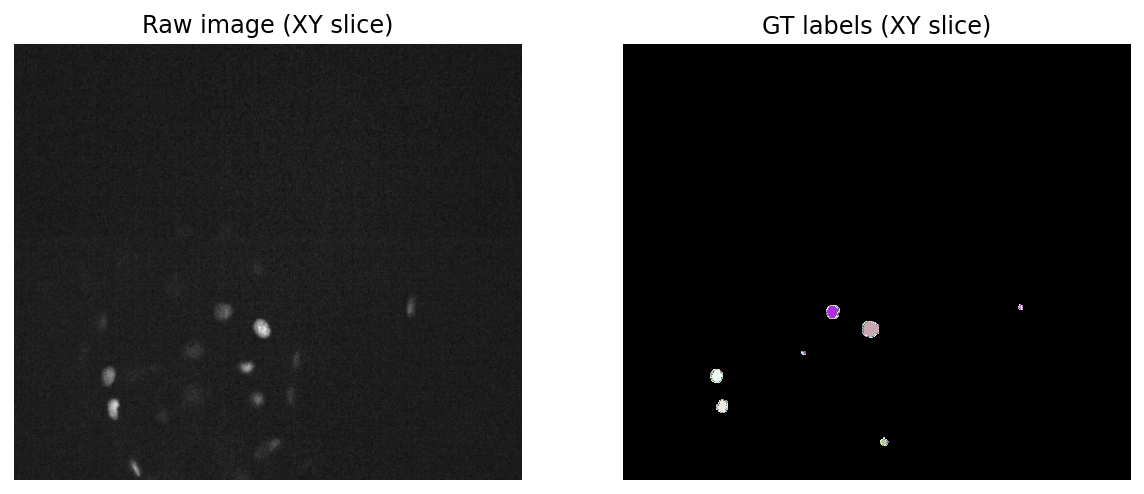

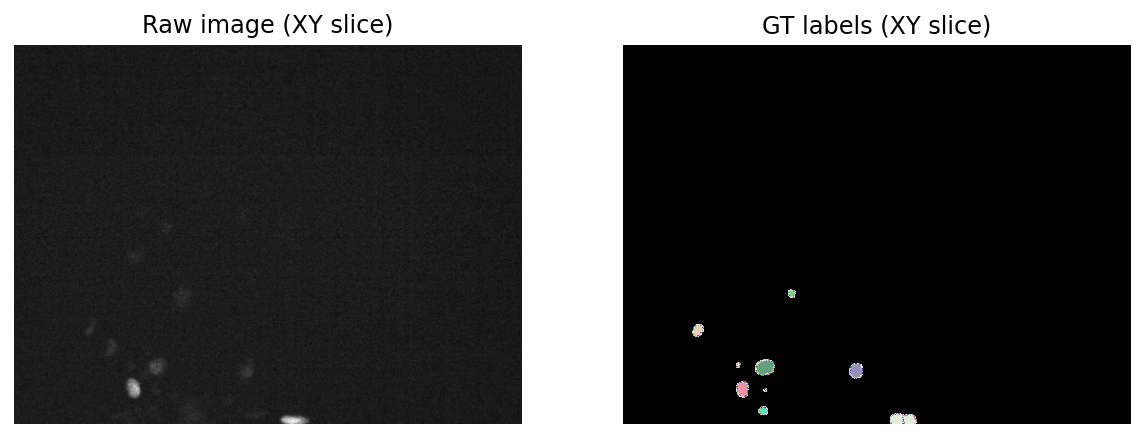

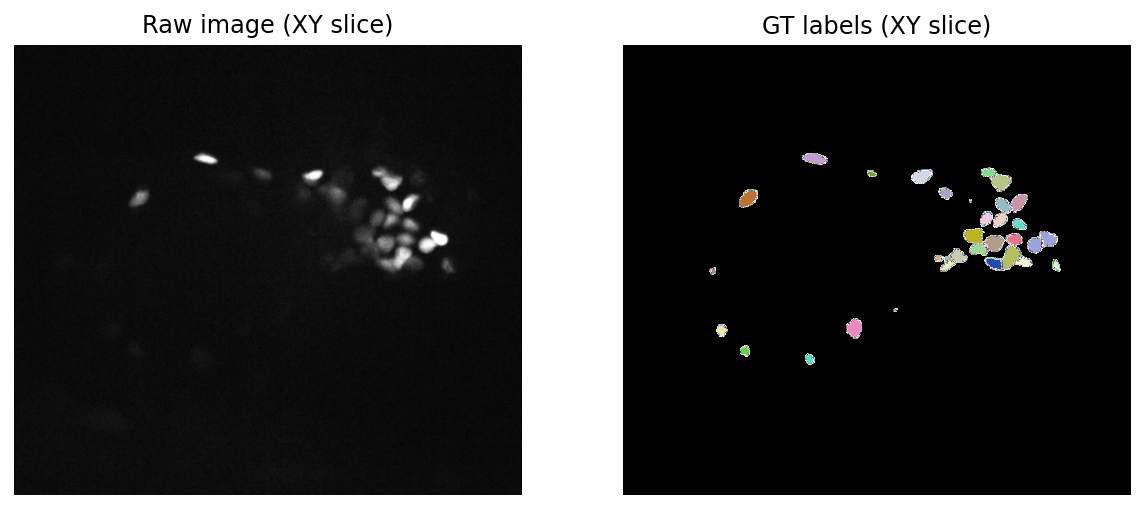

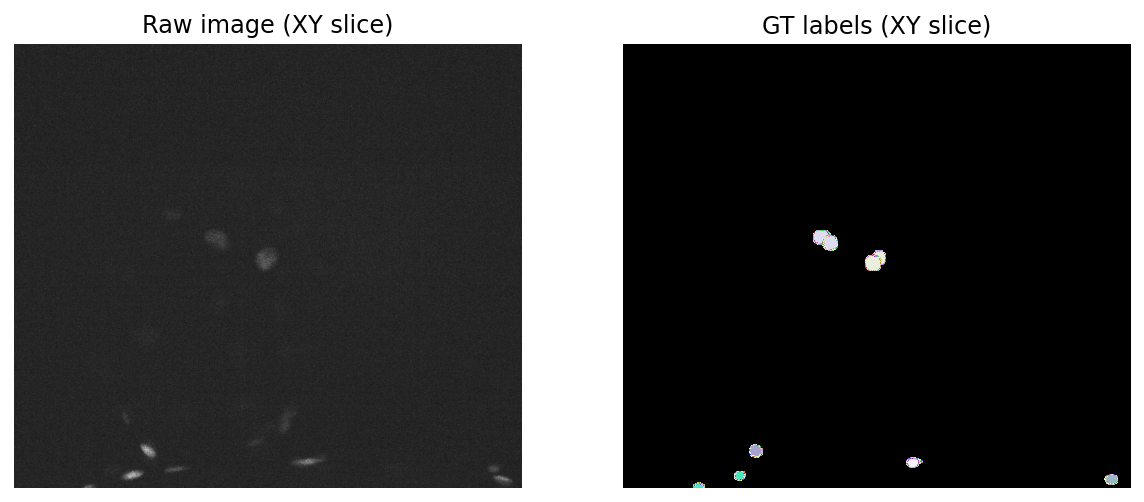

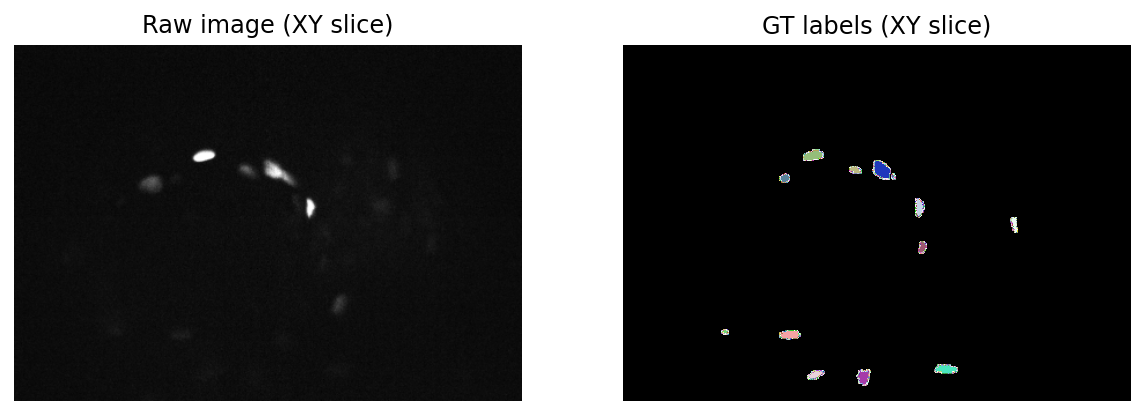

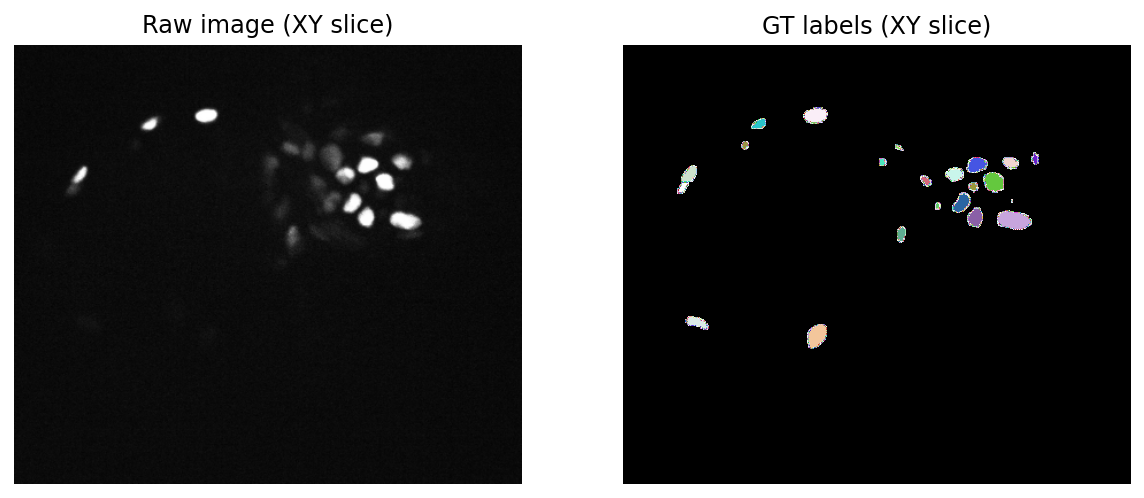

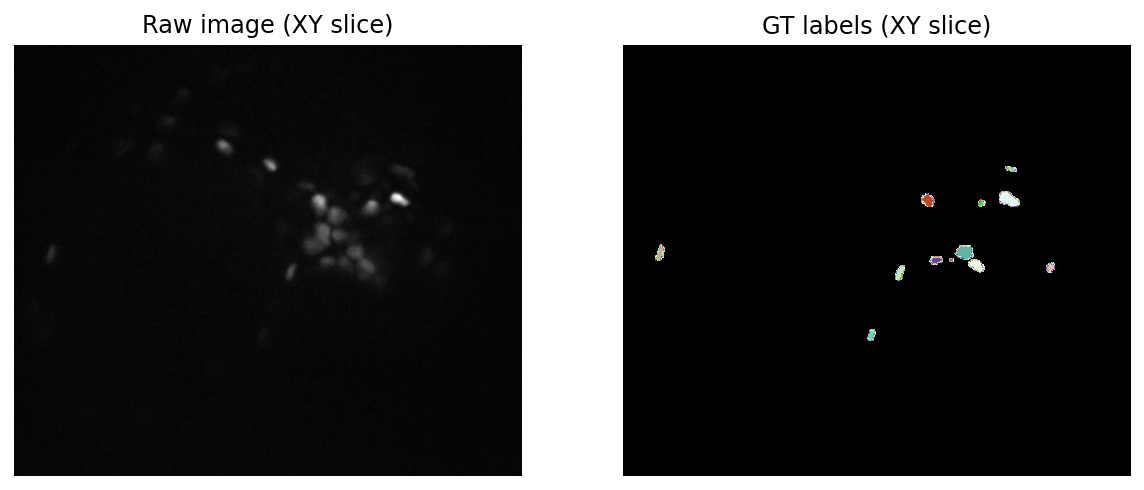

In [5]:
# Plot the raw image and ground truth

i = 0
z=140
for i in range(len(X)):
    Y[i] = label(Y[i], connectivity=1)
    img, lbl = X[i], Y[i]
    assert img.ndim in (3,4)
    
    plt.figure(figsize=(10,10))
    plt.subplot(121); plt.imshow(img[z],cmap='gray');   plt.axis('off'); plt.title('Raw image (XY slice)')
    plt.subplot(122); plt.imshow(lbl[z],cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels (XY slice)')
None;

In [10]:
# Calculate the extent and anisotropy 


extents = calculate_extents(Y)
anisotropy = tuple(np.max(extents) / extents)
print('empirical anisotropy of labeled objects = %s' % str(anisotropy))

empirical anisotropy of labeled objects = (2.1333333333333333, 1.0666666666666667, 1.0)


In [14]:
# 96 is a good default choice based on previous experiments
n_rays = 96

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = True and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = tuple(1 if a > 1.5 else 2 for a in anisotropy) 
# Use rays on a Fibonacci lattice adjusted for measured anisotropy of the training data
rays = Rays_GoldenSpiral(n_rays, anisotropy=anisotropy)

conf = Config3D (
    rays             = rays,
    grid             = grid,
    anisotropy       = anisotropy,
    use_gpu          = use_gpu,
    n_channel_in     = n_channel,
    # adjust for your data below (make patch size as large as possible)
    train_patch_size = (16,64,64),
    train_batch_size = 2,
    train_epochs = 100,
    train_steps_per_epoch = 50,
    train_learning_rate = 0.0003,
    backbone='unet',
    train_tensorboard=True,
    train_reduce_lr = False
)

print(conf)
vars(conf)


  0%|          | 0/3 [02:54<?, ?it/s]


NameError: name 'anisotropy' is not defined

In [13]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    limit_gpu_memory(None, allow_growth=True)

In [11]:
model = StarDist3D(conf, name='stardist3D_iter1', basedir='models')

NameError: name 'conf' is not defined

In [15]:
# Ensure median extent fits within network FOV

median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('ZYX'))

print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

median object size:      [15. 30. 32.]
network field of view :  [26 46 46]


In [16]:
# For data augemtnation, add random gaussian noise, randomly flip and rotate the images

def random_fliprot(img, mask):
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    for ax in axes:
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img

def augmenter(x, y):
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

In [17]:
model.train(X_trn, Y_trn, validation_data=(X_val,Y_val),augmenter=augmenter)

Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Epoch 1/170
50/50 [==============================] - 164s 3s/step - loss: 1.4579 - prob_loss: 0.2201 - dist_loss: 6.1892 - prob_kld: 0.2253 - dist_relevant_mae: 6.1889 - dist_relevant_mse: 68.4127 - dist_dist_iou_metric: 0.0633 - val_loss: 0.9978 - val_prob_loss: 0.1135 - val_dist_loss: 4.4219 - val_prob_kld: 0.1019 - val_dist_relevant_mae: 4.4219 - val_dist_relevant_mse: 32.4785 - val_dist_dist_iou_metric: 0.0176
Epoch 2/170
50/50 [==============================] - 130s 3s/step - loss: 1.0984 - prob_loss: 0.1473 - dist_loss: 4.7555 - prob_kld: 0.1519 - dist_relevant_mae: 4.7552 - dist_relevant_mse: 42.9526 - dist_dist_iou_metric: 0.1072 - val_loss: 0.6805 - val_prob_loss: 0.0738 - val_dist_loss: 3.0336 - val_prob_kld: 0.0622 - val_dist_relevant_mae: 3.0333 - val_dist_relevant_mse: 18.6347 - val_dist_dist_iou_metric: 0.1796
Epoch 3/170
50/50 [==============================] - 129s 3s/step - loss: 0.8232 - prob_loss: 0.1035 - dist_loss: 3.5985 - prob_kld: 0.1076 - dist_relevant_mae: 3.5

# Model Evaluation

In [ ]:
model = StarDist3D(None, name='stardist3D_iter1', basedir='models')

X_val = X[2:7]
Y_val_pred = [model.predict_instances(x, n_tiles = (3,3,3), show_tile_progress=True)[0] 
              for x in tqdm(X_val)]

Loading network weights from 'weights_best.h5'.
Couldn't load thresholds from 'thresholds.json', using default values. (Call 'optimize_thresholds' to change that.)
Using default values: prob_thresh=0.5, nms_thresh=0.4.



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  4%|▎         | 1/27 [01:09<29:59, 69.23s/it]

  7%|▋         | 2/27 [02:15<28:11, 67.67s/it]

 11%|█         | 3/27 [03:24<27:15, 68.14s/it]

 15%|█▍        | 4/27 [04:32<26:06, 68.11s/it]

 19%|█▊        | 5/27 [05:44<25:26, 69.37s/it]

 22%|██▏       | 6/27 [06:43<23:04, 65.91s/it]

 26%|██▌       | 7/27 [07:46<21:36, 64.85s/it]

 30%|██▉       | 8/27 [08:49<20:24, 64.45s/it]

 33%|███▎      | 9/27 [09:48<18:48, 62.72s/it]

 37%|███▋      | 10/27 [10:47<17:28, 61.66s/it]

 41%|████      | 11/27 [11:46<16:14, 60.88s/it]

 44%|████▍     | 12/27 [12:52<15:33, 62.24s/it]

 48%|████▊     | 13/27 [13:51<14:16, 61.18s/it]

 52%|█████▏    | 14/27 [14:50<13:06, 60.52s/it]

Antoine/Validation/mutant_6_iter6.tiff
uint8
[0]
Antoine/Validation/mutant_8_iter6.tiff
uint8
[0]
Antoine/Validation/wt_3_iter6.tiff
uint8
[0]


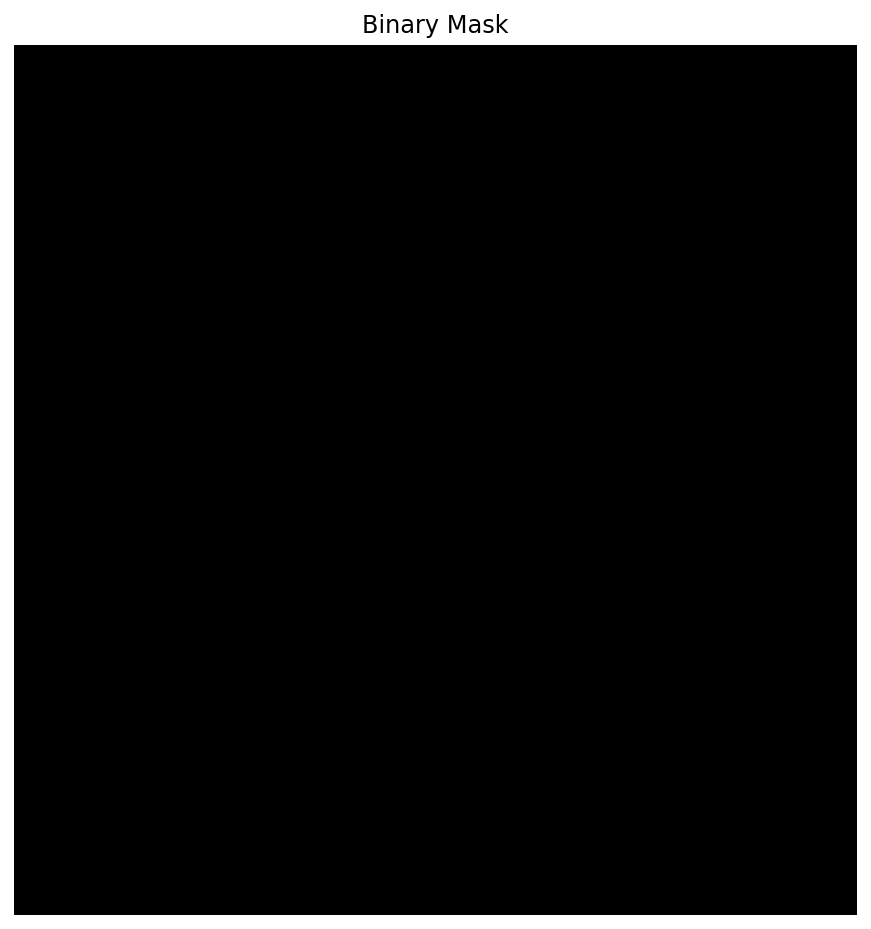

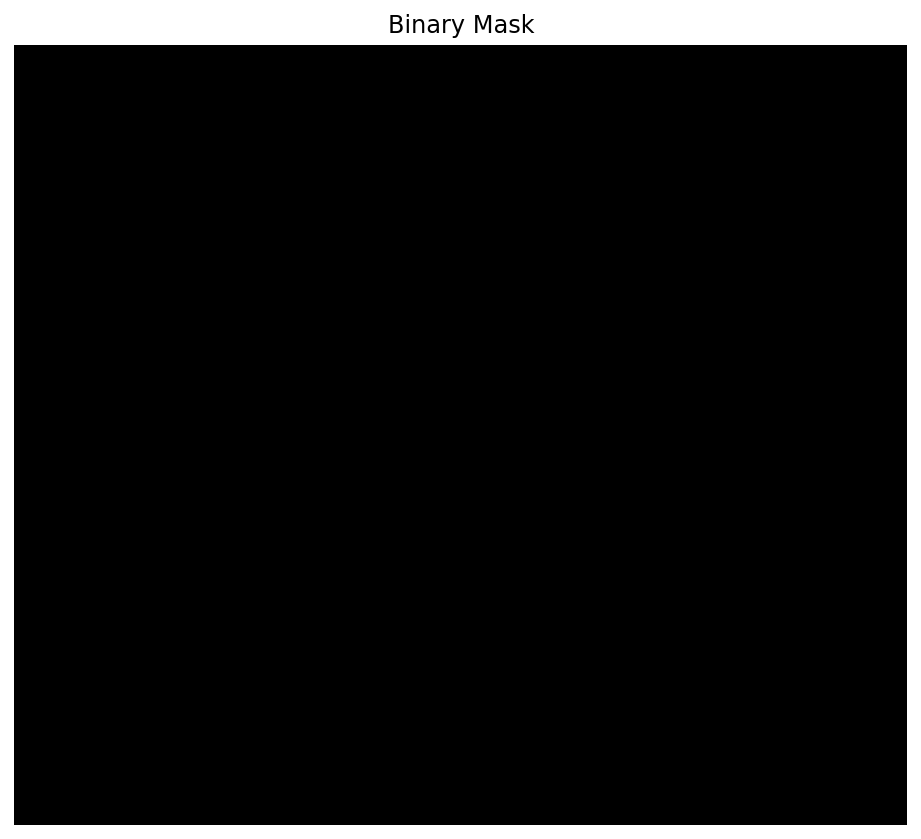

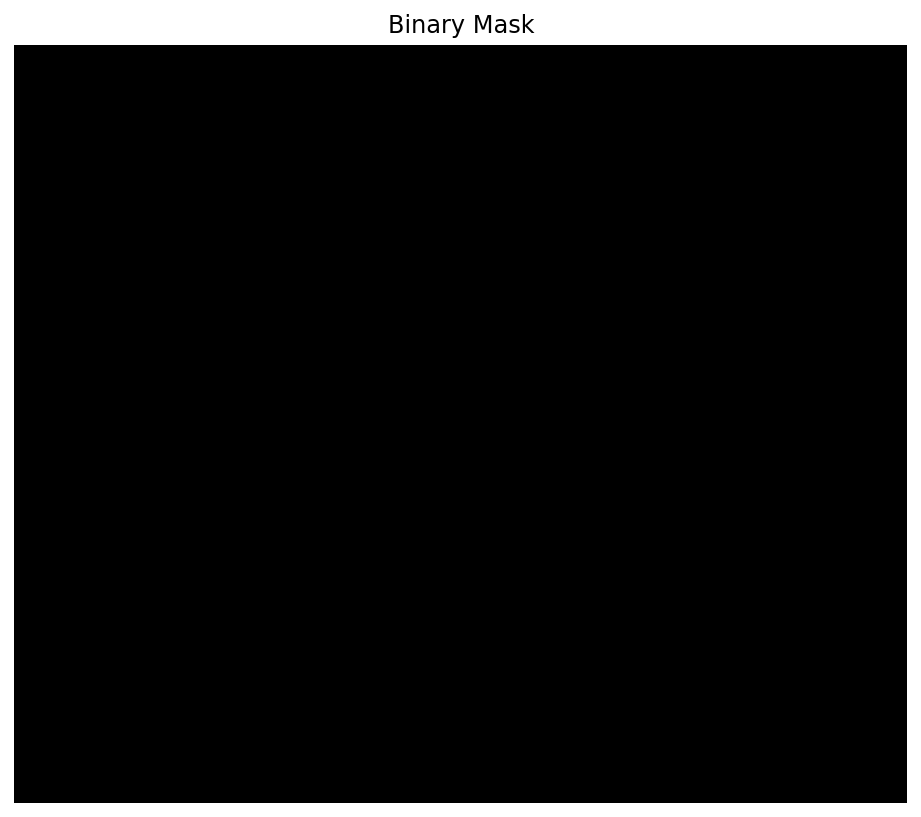

In [6]:
# Save predictions as a binary tiff file

import skimage.morphology as morph
import tifffile

Yname1 = ['Antoine/mutant/mutant_e3.tiff', 
          'Antoine/mutant/mutant_e4.tiff', 
          'Antoine/mutant/mutant_e5.tiff',
          'Antoine/mutant/mutant_e6.tiff', 
          'Antoine/mutant/mutant_e7.tiff']


def label_separating_for_binary(labels):
    label_copy = np.copy(labels)
#     dilation = morph.dilation(label_copy, footprint=morph.ball(1)) # ball of radius 1 corresponds to connectivity 1
    dilation = morph.dilation(label_copy) # ball of radius 1 corresponds to connectivity 1
    difference = dilation - label_copy # You look which voxels take a different value after the dilation operation. These form the 'border' of each nuclei.
    label_copy[difference != 0] = 0 # All the voxels on the borders are set to 0
    return label_copy != 0 # The volume is binarized here


# Uncomment to display display binary image

# i = 0
# z = 150
# for i in range(len(Y_val_pred)):    
#     Y1 = label_separating_for_binary(Y_val_pred[i][:][:][:])
#     print(Yname1[i])
#     plt.figure(figsize=(8,8))
#     plt.imshow(Y1[z],cmap='gray'); plt.axis('off'); plt.title('Binary Mask')
#     Y1 = Y1.astype('uint8')
#     print(Y1.dtype)
#     print(np.unique(Y1))
#     tifffile.imsave(Yname1[i], Y1)
# None;

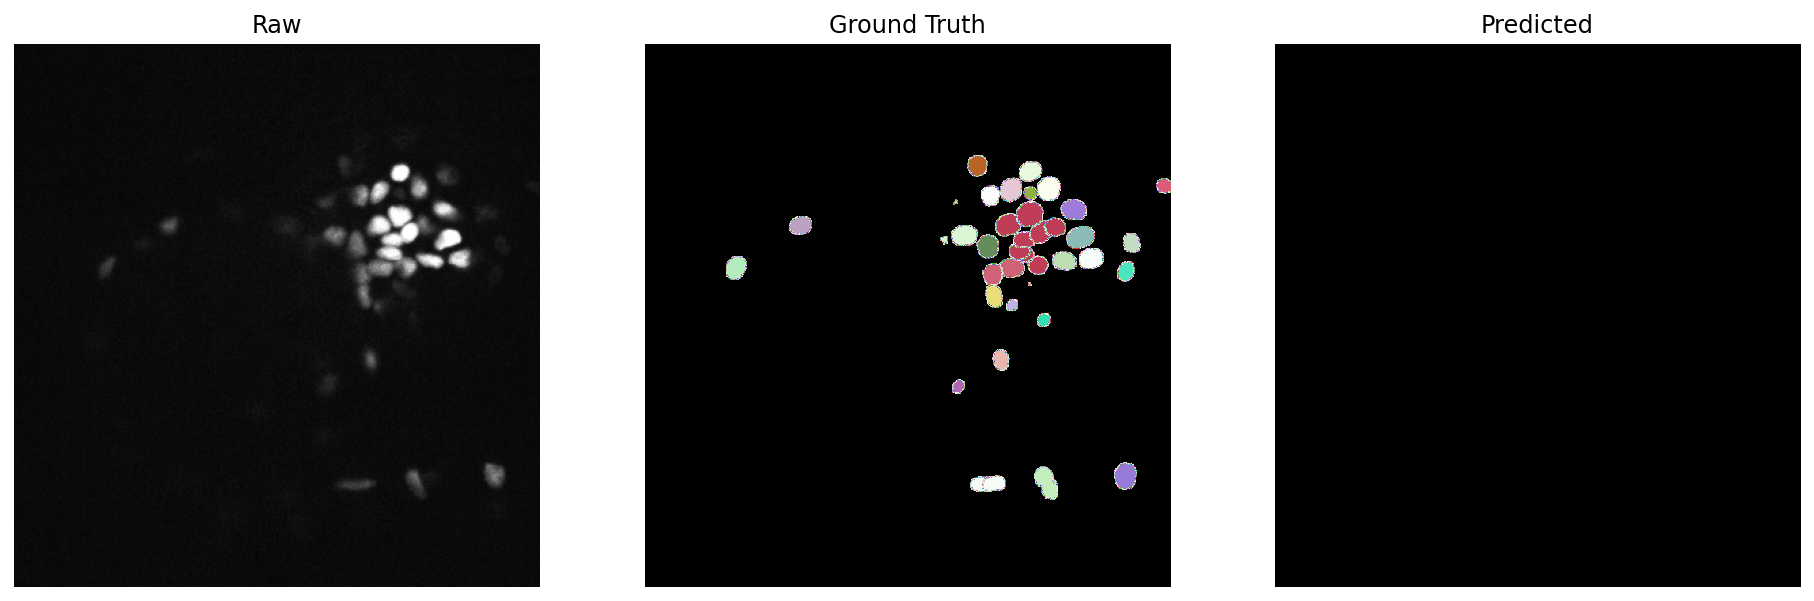

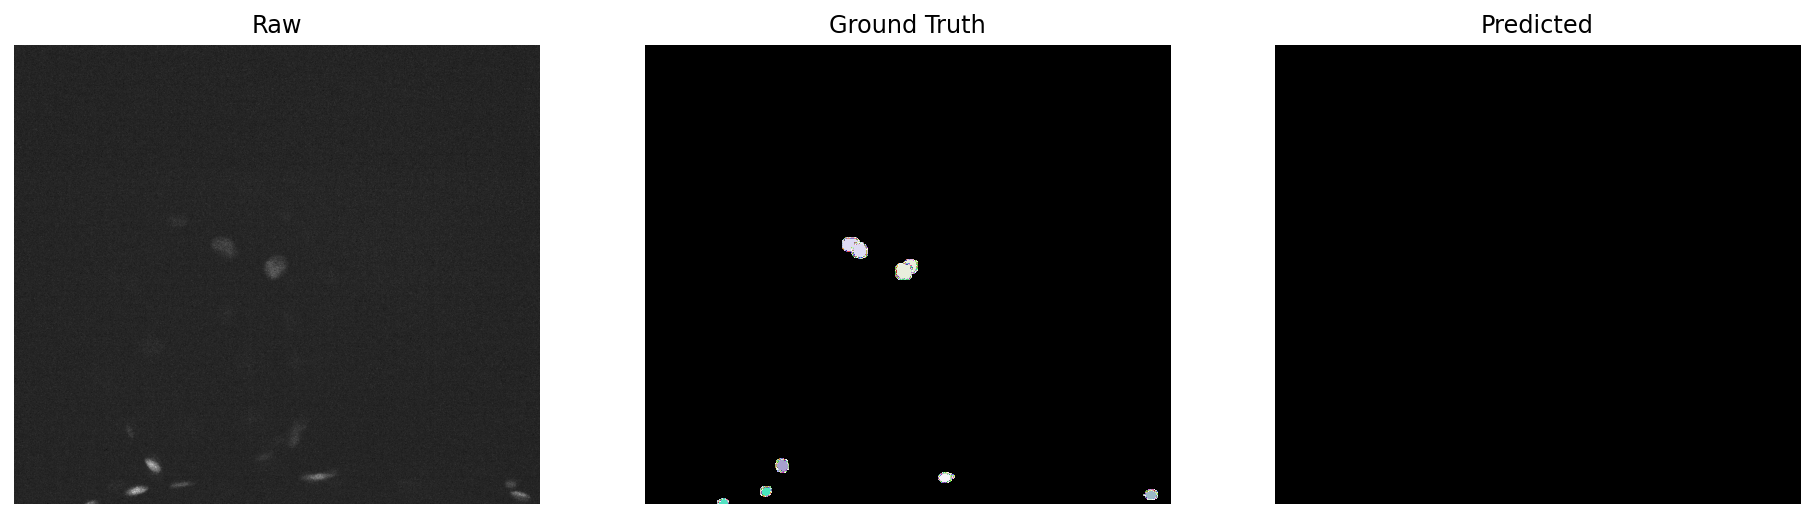

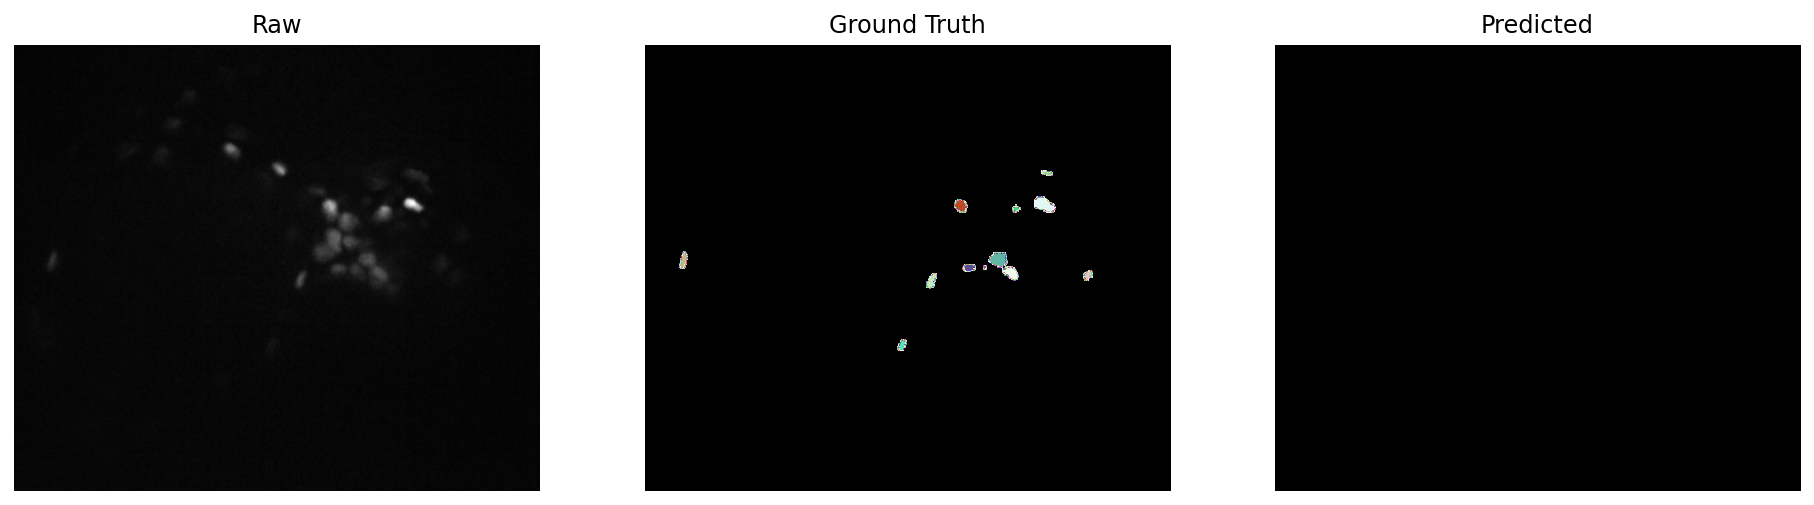

In [7]:
# Print predictions next to ground truth and raw image for comparison

for i in range(len(X_val)):
    Y_val[i] = label(Y_val[i], connectivity=1)
    Y_val_pred[i] = label(Y_val_pred[i], connectivity=1)
    img, lbl = X_val[i],Y_val[i]
    z=140
    plt.figure(figsize=(16,10))
    plt.subplot(131); plt.imshow(img[z],cmap='gray');   plt.axis('off'); plt.title('Raw')
    plt.subplot(132); plt.imshow(lbl[z],cmap=lbl_cmap); plt.axis('off'); plt.title('Ground Truth')
    plt.subplot(133); plt.imshow(Y_val_pred[i][z],cmap=lbl_cmap); plt.axis('off'); plt.title('Predicted')

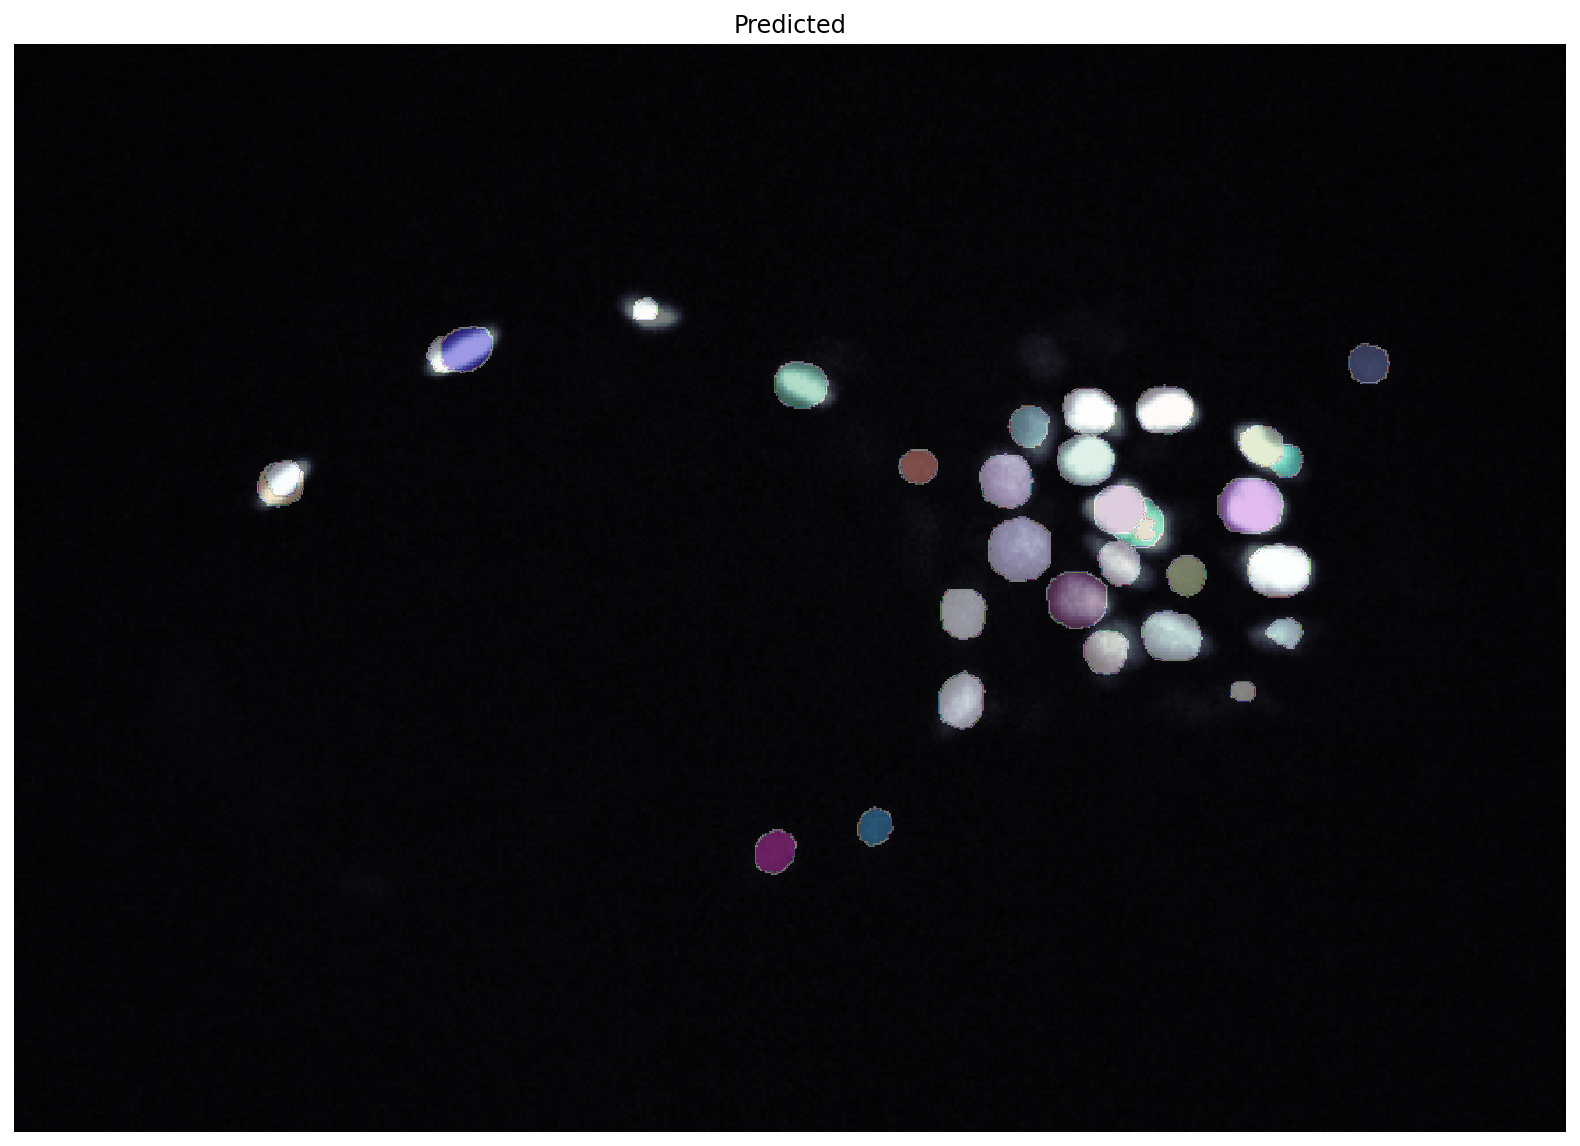

In [9]:
# i want to plot prediction on top of raw image to see if they match

for i in range(len(X_val)):
#     Y_val[i] = label(Y_val[i], connectivity=1)
#     Y_val_pred[i] = label(Y_val_pred[i], connectivity=1)
    img, lbl = X_val[i],Y_val_pred[i]
    z=120
    
    plt.figure(figsize=(16,10))
    plt.imshow(img[z],cmap='bone');   plt.axis('off'); plt.title('Raw')
    plt.imshow(lbl[z],cmap=lbl_cmap, alpha=0.5); plt.axis('off'); plt.title('Predicted')

In [ ]:
# Observe performance metrics for a varying IoU threshold

taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

stats = [matching_dataset(Y_val, Y_val_pred, thresh=0.4, show_progress=False) for t in tqdm(taus)]

print('IoU: 0.1', '\n', stats[taus.index(0.1)])

print('IoU: 0.4', '\n', stats[taus.index(0.4)])

print('IoU: 0.7', '\n', stats[taus.index(0.7)])


fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();

 33%|███▎      | 3/9 [01:42<03:23, 33.95s/it]